#Installazione pacchetti necessari

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations==0.3.0 
!pip install -U --pre segmentation-models 
#!pip install git+https://github.com/qubvel/segmentation_models --user

     |████████████████████████████████| 81kB 2.5MB/s 
     |████████████████████████████████| 21.6MB 1.4MB/s 
     |████████████████████████████████| 634kB 54.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.3.0-cp36-none-any.whl size=46998 sha256=fd692b1bd610493e79c51f0cdd1081a455f36af03863efe35f42bdb348b2dc7f
  Stored in directory: /root/.cache/pip/wheels/f0/20/08/c30ec4f36c3abe52bfb5a980434d4017776f17266071425c9b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=00ba2d55a003ee230f679f74f3d49506aff8527c179a026f66ad114eb865601b
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.

# Connessione a directory Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading Dataset pre processing compresso

In [0]:
import numpy as np
PATH_BASE = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/npy_files/'

In [0]:
dataset_splitted_nneigh_pad_augm = np.load(PATH_BASE + "dataset_splitted_nneigh_pad_augm.npz")

# Caricamento strutture già splittate

In [5]:
x_train = dataset_splitted_nneigh_pad_augm['img_train']
x_val = dataset_splitted_nneigh_pad_augm['img_val']
x_test = dataset_splitted_nneigh_pad_augm['img_test']
mask_train = dataset_splitted_nneigh_pad_augm['mask_train']
mask_val = dataset_splitted_nneigh_pad_augm['mask_val']
mask_test = dataset_splitted_nneigh_pad_augm['mask_test']
map_indexes = dataset_splitted_nneigh_pad_augm['map_indexes']

KeyboardInterrupt: ignored

## Passaggio a 41 channel su validation e train set

Si passa da WxH a WxHxC dove C rappresenta i singoli cluster

In [0]:
recompute = False

In [0]:
def process_channels(reshaped_labels, n_labels):
  reshaped_labels_processed = np.zeros((reshaped_labels.shape[0], reshaped_labels.shape[1], reshaped_labels.shape[2], n_labels), dtype="uint8")
  for n in range(0, reshaped_labels_processed.shape[0]):
    for i in range(0, reshaped_labels_processed.shape[1]):
      for j in range(0, reshaped_labels_processed.shape[2]):
        reshaped_labels_processed[n][i][j][reshaped_labels[n][i][j]] = 1
  return reshaped_labels_processed

In [0]:
if recompute:
  y_train = process_channels(mask_train, 41)
  y_val = process_channels(mask_val, 41)
  np.savez_compressed(PATH_BASE + "normals_centroid_labels_pad_augm_41channels.npz", 
                      y_train = y_train,
                      y_val = y_val)

In [0]:
reshaped_labels_processed_nneigh_pad_load = np.load(PATH_BASE + "normals_centroid_labels_pad_augm_41channels.npz")
y_train = reshaped_labels_processed_nneigh_pad_load["y_train"]
y_val = reshaped_labels_processed_nneigh_pad_load["y_val"]

In [0]:
y_train.shape

# Modellizzazione

## Costruzione modello

In [0]:
import cv2
import tensorflow as tf
import keras
#import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x 

In [0]:
# classes for data loading and preprocessing
class Dataset:
    """Normal surface dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        x (nparray): images
        y (nparray): label
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            x, 
            y, 
            mapping,
    ):
        self.x = x
        self.y = y
        self.mapping = mapping
    
    def __getitem__(self, i):
        image = self.x[i,]
        label = self.y[self.mapping[i],]
        return image, label
        
    def __len__(self):
        return self.x.shape[0]
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        #batch = [np.stack(samples, axis=0) for samples in zip(self.dataset[(start, stop)])]
        #batch = self.dataset[(start,stop)]
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

Costruzione modello

In [0]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [0]:
BACKBONE = 'efficientnetb3'
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 1
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [0]:
# define network parameters
n_classes = 41
activation = 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

Calcolo dei pesi

In [0]:
from sklearn.utils import class_weight
def computeLabelWeights(reshaped_labels):
  labelList = []
  for n in range(0, reshaped_labels.shape[0]):
    for i in range(0, reshaped_labels.shape[1]):
      for j in range(0, reshaped_labels.shape[2]):
        labelList.append(reshaped_labels[n][i][j])

  return class_weight.compute_class_weight('balanced',np.unique(labelList),labelList).tolist()

In [0]:
if recompute:
  dataset_preprocess_nneigh_pad_augm = np.load(PATH_BASE + "dataset_pre_processing_nneigh_pad.npz")
  reshaped_labels_zeropadding = dataset_preprocess_nneigh_pad_augm['reshaped_labels_zeropadding']
  class_weight = computeLabelWeights(reshaped_labels_zeropadding)
  np.save(PATH_BASE + "label_weights_nneigh_pad.npy", class_weight)

In [0]:
class_weights = np.load(PATH_BASE + "label_weights_nneigh_pad.npy")

In [0]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [0]:
# Dataset for train images
train_dataset = Dataset(
    x_train, 
    y_train,
    mapping = map_indexes
)

# Dataset for validation images
valid_dataset = Dataset(
    x_val, 
    y_val,
    mapping = np.arange(x_val.shape[0])
)

train_dataloader = Dataloder(train_dataset, TRAIN_BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, VAL_BATCH_SIZE, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (TRAIN_BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (TRAIN_BATCH_SIZE, 320, 320, 41)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_augm.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [0]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

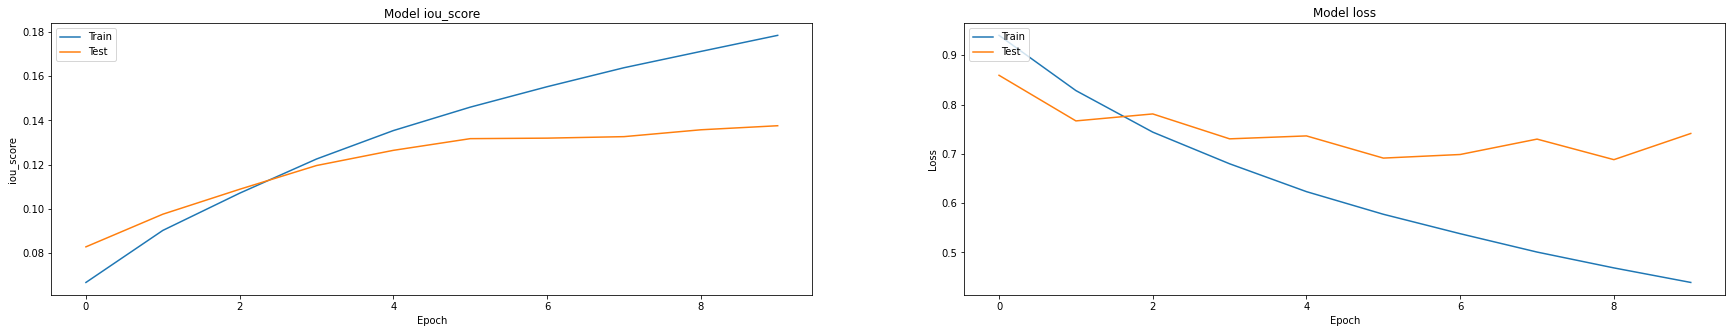

In [0]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Calcolo output predizionale della rete

In [0]:
from keras.models import load_model
model.load_weights("best_model.h5")

In [0]:
y_test_p = model.predict(x_test, batch_size=1)

In [0]:
np.save(PATH_BASE + "prediction_test_padded.npy", y_test_p)